# Import data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.preprocessing import MultiLabelBinarizer


df = pd.read_csv('cosmetics.csv')  
df = df.dropna(subset=['Ingredients']) 
df['Ingredients'] = df['Ingredients'].str.lower()
df['Ingredients'] = df['Ingredients'].str.replace(r'\baqua\b', 'water', regex=True)
syn_dict = {
    'vitamin e': 'tocopherol',
}
def unify_synonyms(ingr_str):
    for k, v in syn_dict.items():
        ingr_str = re.sub(r'\b{}\b'.format(k), v, ingr_str)
    return ingr_str

df['Ingredients'] = df['Ingredients'].apply(unify_synonyms)
print(df['Ingredients'].head(10))
df['ingredient_list'] = df['Ingredients'].apply(lambda x: [i.strip() for i in x.split(',') if i.strip() != ''])
mlb = MultiLabelBinarizer()
ingredient_matrix = mlb.fit_transform(df['ingredient_list'])
ingredient_df = pd.DataFrame(ingredient_matrix, columns=mlb.classes_, index=df.index)
df_final = pd.concat([df, ingredient_df], axis=1)
print(df_final.head())
print(df_final.shape)


0    algae (seaweed) extract, mineral oil, petrolat...
1    galactomyces ferment filtrate (pitera), butyle...
2    water, dicaprylyl carbonate, glycerin, ceteary...
3    algae (seaweed) extract, cyclopentasiloxane, p...
4    water, snail secretion filtrate, phenyl trimet...
5    water, saccharomyces/camellia sinensis leaf/cl...
6    water, glycerin, caprylic/ capric triglyceride...
7    100% unrefined sclerocraya birrea (marula) ker...
8    water, glycerin, cyclohexasiloxane, squalane, ...
9    algae (seaweed) extract, mineral oil, petrolat...
Name: Ingredients, dtype: object
         Label           Brand                                           Name  \
0  Moisturizer          LA MER                                Crème de la Mer   
1  Moisturizer           SK-II                       Facial Treatment Essence   
2  Moisturizer  DRUNK ELEPHANT                     Protini™ Polypeptide Cream   
3  Moisturizer          LA MER                    The Moisturizing Soft Cream   
4  Moisturiz

# EDA

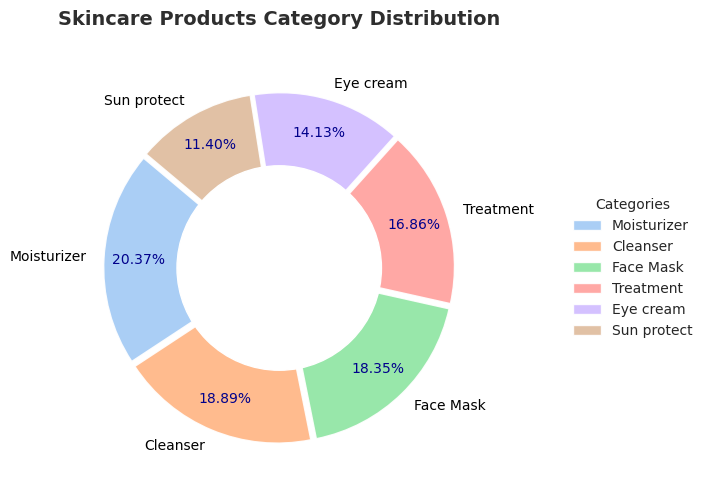

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid", {'grid.linestyle': '--'})
sns.set_palette("pastel")
plt.rcParams['font.family'] = 'DejaVu Sans' 
category_counts = df['Label'].value_counts()
plt.figure(figsize=(8, 8))
explode = [0.03] * len(category_counts) 
wedges, texts, autotexts = plt.pie(
    category_counts,
    labels=category_counts.index,
    autopct='%1.2f%%',
    startangle=140,
    pctdistance=0.8,
    explode=explode,
    textprops={'fontsize': 10, 'color': 'black'},
    wedgeprops={'linewidth': 1, 'edgecolor': 'white', 'alpha': 0.9},
    colors=sns.color_palette("pastel")  
)
for autotext in autotexts:
    autotext.set_size(10)
    autotext.set_color('darkblue')

centre_circle = plt.Circle((0,0), 0.6, fc='white')
plt.gca().add_artist(centre_circle)

plt.legend(
    wedges,
    category_counts.index,
    title="Categories",
    loc="center right",
    bbox_to_anchor=(1, 0, 0.5, 1),
    frameon=False
)
plt.title('Skincare Products Category Distribution\n', 
          fontsize=14, 
          fontweight='bold', 
          color='#2E2E2E')
plt.tight_layout()
plt.show()

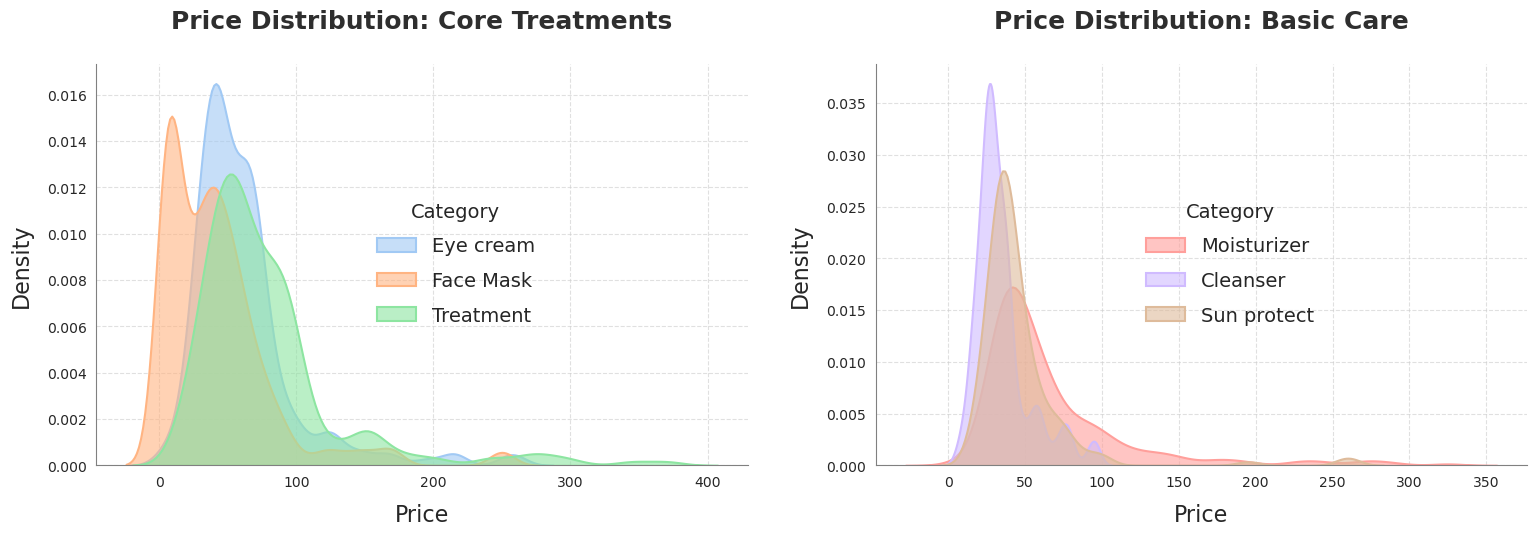

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid", {'grid.linestyle': '--'})
plt.rcParams['font.family'] = 'DejaVu Sans'
colors = sns.color_palette("pastel") 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
categories_1 = ['Eye cream', 'Face Mask', 'Treatment']
for i, cat in enumerate(categories_1):
    subset = df[df['Label'] == cat]
    sns.kdeplot(
        data=subset, x='Price',
        label=cat,
        color=colors[i],        
        fill=True,
        alpha=0.6,             
        linewidth=1.5,         
        bw_adjust=0.65,  
        ax=ax1
    )

ax1.set_xlabel('Price', fontsize=16, labelpad=10)
ax1.set_ylabel('Density', fontsize=16, labelpad=10)
ax1.set_title('Price Distribution: Core Treatments\n', 
             fontsize=18, fontweight='bold', color='#2E2E2E')
categories_2 = ['Moisturizer', 'Cleanser', 'Sun protect']
for i, cat in enumerate(categories_2, start=3): 
    subset = df[df['Label'] == cat]
    sns.kdeplot(
        data=subset, x='Price',
        label=cat,
        color=colors[i],      
        fill=True,
        alpha=0.6,
        linewidth=1.5,
        bw_adjust=0.65,
        ax=ax2
    )

ax2.set_xlabel('Price', fontsize=16, labelpad=10)
ax2.set_ylabel('Density', fontsize=16, labelpad=10)
ax2.set_title('Price Distribution: Basic Care\n', 
             fontsize=18, fontweight='bold', color='#2E2E2E')

for ax in [ax1, ax2]:
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('#808080')
    ax.spines['bottom'].set_color('#808080')
    ax.legend(
        title='Category',
        title_fontsize=14,
        fontsize=14,
        frameon=False,
        labelspacing=0.8,
        bbox_to_anchor=(0.7, 0.7),  
        loc='upper right'
    )
plt.tight_layout(pad=3)
plt.show()

<Figure size 1000x600 with 0 Axes>

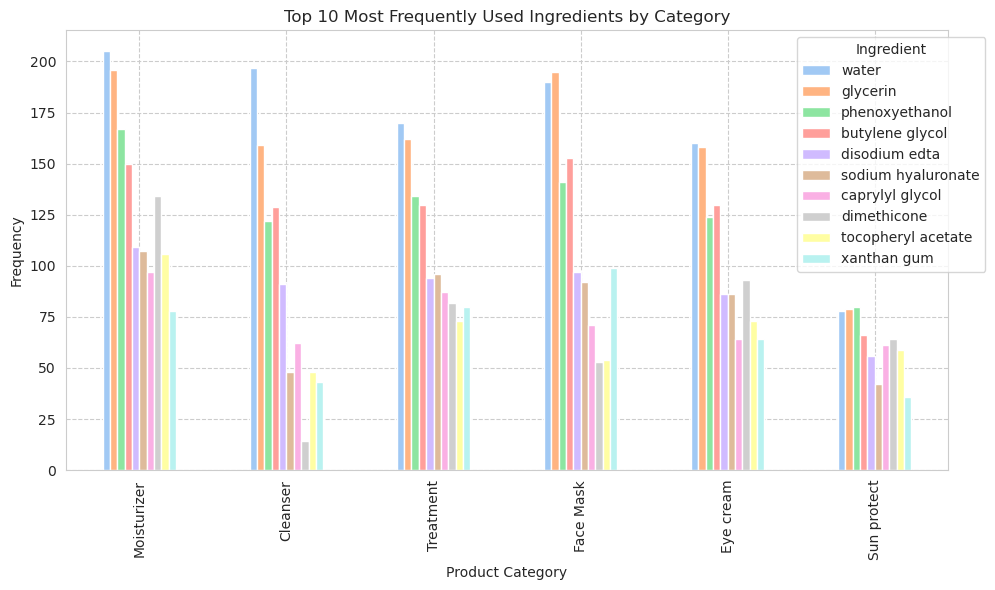

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
ingredient_cols = [col for col in df_final.columns 
                   if col not in ['Label', 'Brand', 'Name', 'Price', 'Rank', 'Ingredients', 'Combination',
       'Dry', 'Normal', 'Oily', 'Sensitive','ingredient_list']]
global_sum = df_final[ingredient_cols].sum().sort_values(ascending=False)
top_10_ing = global_sum.head(10).index 
category_list = df_final['Label'].unique()
freq_df = pd.DataFrame(0, index=category_list, columns=top_10_ing)

for cat in category_list:
    subset = df_final[df_final['Label'] == cat]
    freq = subset[top_10_ing].sum()
    freq_df.loc[cat] = freq
plt.figure(figsize=(10, 6))
freq_df.plot(kind='bar', figsize=(10,6))  
plt.title('Top 10 Most Frequently Used Ingredients by Category')
plt.xlabel('Product Category')
plt.ylabel('Frequency')
plt.legend(title='Ingredient', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()


TF-IDF shape: (1281, 4263)
t-SNE embedding shape: (1281, 2)


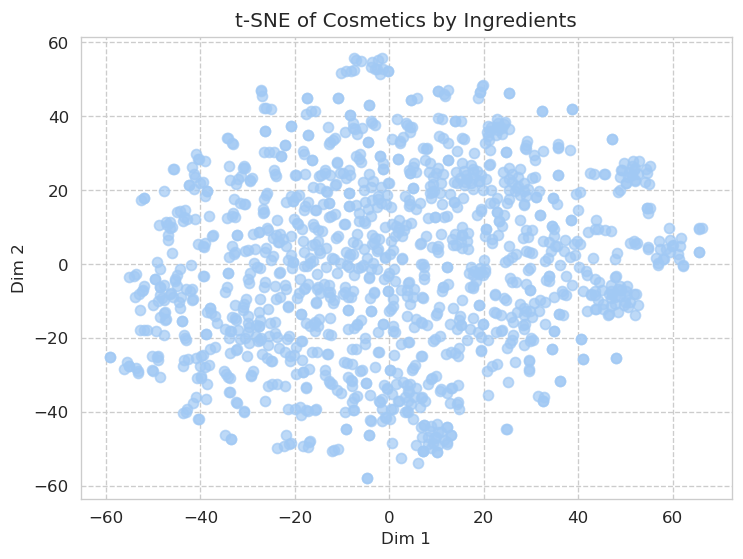

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

ingredient_docs =df['Ingredients']

vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(ingredient_docs)  # shape = (n_products, n_terms)
print("\nTF-IDF shape:", tfidf_matrix.shape)
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
tfidf_emb = tsne.fit_transform(tfidf_matrix.toarray())  
print("t-SNE embedding shape:", tfidf_emb.shape)
if 'category' in df.columns:
    categories = df['category'].unique().tolist()
    color_map = {cat: idx for idx, cat in enumerate(categories)}
    c = df['category'].map(color_map).values
    plt.figure(figsize=(7,5), dpi=120)
    sc = plt.scatter(tfidf_emb[:,0], tfidf_emb[:,1], c=c, cmap='tab10', alpha=0.7)
    plt.title("t-SNE of Cosmetics by Ingredients (colored by category)")
    plt.xlabel("Dim 1")
    plt.ylabel("Dim 2")
    cb = plt.colorbar(sc, ticks=range(len(categories)))
    cb.ax.set_yticklabels(categories)  
    plt.show()
else:
    plt.figure(figsize=(7,5), dpi=120)
    plt.scatter(tfidf_emb[:,0], tfidf_emb[:,1], alpha=0.7)
    plt.title("t-SNE of Cosmetics by Ingredients")
    plt.xlabel("Dim 1")
    plt.ylabel("Dim 2")
    plt.show()


# Jaccard

In [6]:
from sklearn.metrics import jaccard_score
import pandas as pd

def Jaccard(target_name):
    ms_df = df_final[df_final['Label'] == "Moisturizer"].set_index('Name')
    bin_df = ms_df.iloc[:, 12:]
    if target_name not in bin_df.index:
        raise ValueError(f"no '{target_name}' ")
    target_vec = bin_df.loc[target_name].values
    sims = bin_df.apply(lambda row: 
                        jaccard_score(target_vec, row.values),
                        axis=1)
    sims = sims.drop(index=target_name)
    top10 = sims.nlargest(10)
    brands = ms_df.loc[top10.index, 'Brand'].values
    prices = ms_df.loc[top10.index, 'Price'].values
    result = pd.DataFrame({
        'Product': top10.index,
        'Brand':   brands,
        'Price':   prices,
        'Jaccard': top10.values
    })
    return result.reset_index(drop=True)
print(Jaccard("Crème de la Mer"))


                                             Product    Brand  Price   Jaccard
0  Little Miss Miracle Limited-Edition Crème de l...   LA MER    325  1.000000
1                               Crème de la Mer Mini   LA MER     85  1.000000
2                      The Moisturizing Matte Lotion   LA MER    270  0.274725
3                       The Moisturizing Soft Lotion   LA MER    270  0.268817
4                               The Concentrate Mini   LA MER    190  0.268657
5                                    The Renewal Oil   LA MER    245  0.244444
6                               The Renewal Oil Mini   LA MER    130  0.244444
7                        The Moisturizing Soft Cream   LA MER    175  0.237113
8  BIENFAIT MULTI-VITAL NIGHT - High Potency Nigh...  LANCÔME     52  0.162162
9               Vitamin Nectar Antioxidant Face Mist    FRESH     44  0.116667


# TFIDF_Cosine

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

def TFIDF_Cosine(target_name):
    ms_df = df_final[df_final['Label'] == "Moisturizer"].set_index('Name')
    texts = ms_df['Ingredients'].tolist()
    names = ms_df.index.tolist()
    vectorizer = TfidfVectorizer(token_pattern=r"(?u)\b\w+\b")
    tfidf_matrix = vectorizer.fit_transform(texts)
    if target_name not in names:
        raise ValueError(f"didn't find '{target_name}' ")
    idx = names.index(target_name)
    target_vec = tfidf_matrix[idx]
    sims = cosine_similarity(tfidf_matrix, target_vec).flatten()
    sims_series = pd.Series(sims, index=names).drop(index=target_name)
    top10 = sims_series.nlargest(10)
    brands = ms_df.loc[top10.index, 'Brand'].values
    prices = ms_df.loc[top10.index, 'Price'].values
    result = pd.DataFrame({
        'Product':      top10.index,
        'Brand':        brands,
        'Price':        prices,
        'CosineTFIDF':  top10.values
    })
    return result.reset_index(drop=True)

TFIDF_Cosine("Crème de la Mer")

,Product,Brand,Price,CosineTFIDF
0,Little Miss Miracle Limited-Edition Crème de l...,LA MER,325,1.000000
1,Crème de la Mer Mini,LA MER,85,1.000000
2,The Concentrate Mini,LA MER,190,0.612960
3,The Moisturizing Soft Cream,LA MER,175,0.598280
4,The Moisturizing Matte Lotion,LA MER,270,0.593625
5,The Moisturizing Soft Lotion,LA MER,270,0.593589
6,The Renewal Oil,LA MER,245,0.554019
7,The Renewal Oil Mini,LA MER,130,0.554019
8,BIENFAIT MULTI-VITAL NIGHT - High Potency Nigh...,LANCÔME,52,0.323060
9,Immortelle Divine Cream,L'OCCITANE,110,0.254560


# Bert Model From Hugging Face

In [14]:
from transformers import AutoTokenizer, AutoModel
import torch
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import warnings
warnings.filterwarnings("ignore")  # 忽略所有警告
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")
bert_model = AutoModel.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")

def _encode_texts(texts):
    encoded = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")
    with torch.no_grad():
        out = bert_model(**encoded)
    # out.last_hidden_state: [batch, seq_len, dim]
    mask = encoded.attention_mask.unsqueeze(-1)  # [batch, seq_len, 1]
    summed = (out.last_hidden_state * mask).sum(dim=1)   # [batch, dim]
    counts = mask.sum(dim=1)                            # [batch, 1]
    embeddings = summed / counts                        # mean-pooling
    return embeddings.cpu().numpy()                  

def BERT_Similarity(target_name,df_final):
    ms_df = df_final[df_final['Label']=="Moisturizer"].set_index('Name')
    if target_name not in ms_df.index:
        raise ValueError(f"no '{target_name}'")
    texts = ms_df['Ingredients'].tolist()
    names = ms_df.index.tolist()
    embeddings = _encode_texts(texts)
    idx = names.index(target_name)
    target_emb = embeddings[idx].reshape(1, -1)
    sims = cosine_similarity(embeddings, target_emb).flatten()
    sims_series = pd.Series(sims, index=names).drop(index=target_name)
    top10 = sims_series.nlargest(10)
    brands = ms_df.loc[top10.index, 'Brand'].values
    prices = ms_df.loc[top10.index, 'Price'].values
    return pd.DataFrame({
        'Product':     top10.index,
        'Brand':       brands,
        'Price':       prices,
        'CosineBERT':  top10.values
    }).reset_index(drop=True)
print(BERT_Similarity("Crème de la Mer",df_final))

                                             Product         Brand  Price  \
0  Little Miss Miracle Limited-Edition Crème de l...        LA MER    325   
1                               Crème de la Mer Mini        LA MER     85   
2                               The Concentrate Mini        LA MER    190   
3             Dramatically Different Hydrating Jelly      CLINIQUE     28   
4                            Luminous Dewy Skin Mist        TATCHA     48   
5                                 Water Bank Essence       LANEIGE     36   
6                   Lotus Youth Preserve Moisturizer         FRESH     45   
7                      Moisture Surge Overnight Mask      CLINIQUE     35   
8  Amazonian Clay BB Tinted Moisturizer Broad Spe...         TARTE     36   
9       Sheer Transformation® Perfecting Moisturizer  OLEHENRIKSEN     38   

   CosineBERT  
0    1.000000  
1    1.000000  
2    0.881759  
3    0.872170  
4    0.868820  
5    0.862687  
6    0.859078  
7    0.856942  
8    0.8

## Model Improvements - Previously Ingredients had been preprocessed in Excel and products with incomplete ingredients were removed. The Ingredients column in the new df_new retains more non-standardized parts that need to be understood using semantics.

In [12]:
def BERT_Similarity_new(target_name,df_final):
    ms_df = df_final[df_final['Label']=="Moisturizer"].set_index('Name')
    if target_name not in ms_df.index:
        raise ValueError(f"no '{target_name}' ")
    texts = ms_df['Ingredients'].tolist()
    names = ms_df.index.tolist()
    embeddings = _encode_texts(texts)
    idx = names.index(target_name)
    target_emb = embeddings[idx].reshape(1, -1)
    sims = cosine_similarity(embeddings, target_emb).flatten()
    sims_series = pd.Series(sims, index=names).drop(index=target_name)
    top10 = sims_series.nlargest(10)
    brands = ms_df.loc[top10.index, 'Brand'].values
    prices = ms_df.loc[top10.index, 'Price'].values
    return pd.DataFrame({
        'Product':     top10.index,
        'Brand':       brands,
        'Price':       prices,
        'CosineBERT':  top10.values
    }).reset_index(drop=True)
df_new=pd.read_csv("cosmetics_new.csv")
print(BERT_Similarity_new("Crème de la Mer",df_new))

                                             Product        Brand  Price  \
0  Little Miss Miracle Limited-Edition Crème de l...       LA MER    325   
1                               Crème de la Mer Mini       LA MER     85   
2                               The Concentrate Mini       LA MER    190   
3             Dramatically Different Hydrating Jelly     CLINIQUE     28   
4                            Luminous Dewy Skin Mist       TATCHA     48   
5                                 Water Bank Essence      LANEIGE     36   
6                   Lotus Youth Preserve Moisturizer        FRESH     45   
7                      Moisture Surge Overnight Mask     CLINIQUE     35   
8                      Watermelon Glow Sleeping Mask  GLOW RECIPE     45   
9  Drink of H2O Hydrating Boost Moisturizer Rainf...        TARTE     39   

   CosineBERT  
0    1.000000  
1    1.000000  
2    0.881759  
3    0.872170  
4    0.868820  
5    0.862687  
6    0.859078  
7    0.856942  
8    0.849569  
9  

## Further add core component identification to weight the components

In [15]:
from tqdm import tqdm
def BERT_Similarity_final(target_name, df_new, top_n=10):
    df_moist = df_new[df_new['Label'] == 'Moisturizer']
    target_row = df_moist[df_moist['Name'] == target_name]
    if target_row.empty:
        print("Target product not found in Moisturizer category.")
        return None
    target_ingredients = str(target_row.iloc[0]['Ingredients'])
    text = target_ingredients
    text = re.sub(r'(?<=[A-Za-z])-\s*(?=[A-Za-z])', '', text)
    core_set = set()
    if "Active Ingredients:" in text:
        start_idx = text.index("Active Ingredients:") + len("Active Ingredients:")
        remaining = text[start_idx:]
        if "Ingredients:" in remaining:
            actives_str = remaining.split("Ingredients:")[0]
        else:
            actives_str = remaining
        for ingr in actives_str.split(','):
            ingr = ingr.strip()
            if ingr:
                ingr = ingr.lstrip(' -–').rstrip('.; ')
                core_set.add(ingr)
    elif ':' in text:
        part = text.split(':')[0]
        for ingr in part.split(','):
            ingr = ingr.strip()
            if ingr:
                ingr = ingr.lstrip(' -–').rstrip('.; ')
                core_set.add(ingr)
    all_ingredients = [ing.strip() for ing in text.split(',') if ing.strip()]
    if len(all_ingredients) < 5:
        core_set.update(all_ingredients)
    for ingr in all_ingredients:
        if '%' in ingr:
            raw = ingr.strip().rstrip('.,; ')
            if '%' in raw:
                name_part = raw.split('%')[0]
                name_part = re.split(r'\d', name_part)[0].strip()
                ingr_name = name_part if name_part else raw
            else:
                ingr_name = raw
            ingr_name = ingr_name.lstrip(' -–').rstrip('.; ')
            if ingr_name:
                core_set.add(ingr_name)
    if not core_set:
        core_set.update(all_ingredients)
    core_text = ', '.join(core_set) if core_set else ''
    tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
    model = AutoModel.from_pretrained('bert-base-cased')
    model.eval()
    if core_text:
        inputs = tokenizer(core_text, return_tensors='pt', truncation=True, padding=True)
        with torch.no_grad():
            outputs = model(**inputs)
            target_embedding = outputs.last_hidden_state[:, 0, :].squeeze(0)
    else:
        target_embedding = torch.zeros(model.config.hidden_size)
    results = []
    for _, row in tqdm(df_moist[df_moist['Name'] != target_name].iterrows(),
                       total=len(df_moist[df_moist['Name'] != target_name]),
                       desc="Computing similarities"):
        name = row['Name']; brand = row['Brand']; price = row['Price']
        ing_text = str(row['Ingredients'])
        t = re.sub(r'(?<=[A-Za-z])-\s*(?=[A-Za-z])', '', ing_text)
        core_set2 = set()
        if "Active Ingredients:" in t:
            si = t.index("Active Ingredients:") + len("Active Ingredients:")
            rem = t[si:]
            if "Ingredients:" in rem:
                act_str = rem.split("Ingredients:")[0]
            else:
                act_str = rem
            for ingr in act_str.split(','):
                ingr = ingr.strip()
                if ingr:
                    ingr = ingr.lstrip(' -–').rstrip('.; ')
                    core_set2.add(ingr)
        elif ':' in t:
            part2 = t.split(':')[0]
            for ingr in part2.split(','):
                ingr = ingr.strip()
                if ingr:
                    ingr = ingr.lstrip(' -–').rstrip('.; ')
                    core_set2.add(ingr)
        all_ing2 = [ing.strip() for ing in t.split(',') if ing.strip()]
        if len(all_ing2) < 5:
            core_set2.update(all_ing2)
        for ingr in all_ing2:
            if '%' in ingr:
                raw = ingr.strip().rstrip('.,; ')
                if '%' in raw:
                    name_part = raw.split('%')[0]
                    name_part = re.split(r'\d', name_part)[0].strip()
                    ingr_name = name_part if name_part else raw
                else:
                    ingr_name = raw
                ingr_name = ingr_name.lstrip(' -–').rstrip('.; ')
                if ingr_name:
                    core_set2.add(ingr_name)
        if not core_set2:
            core_set2.update(all_ing2)
        core_text2 = ', '.join(core_set2) if core_set2 else ''
        if core_text2:
            inputs2 = tokenizer(core_text2, return_tensors='pt', truncation=True, padding=True)
            with torch.no_grad():
                outputs2 = model(**inputs2)
                embed2 = outputs2.last_hidden_state[:, 0, :].squeeze(0)
            if torch.norm(target_embedding) > 0 and torch.norm(embed2) > 0:
                cos_sim = torch.dot(target_embedding, embed2) / (torch.norm(target_embedding) * torch.norm(embed2))
                cos_sim = cos_sim.item()
            else:
                cos_sim = 0.0
        else:
            cos_sim = 0.0
        results.append((name, brand, price, cos_sim))
    results.sort(key=lambda x: x[3], reverse=True)
    top_results = results[:top_n]
    return pd.DataFrame(top_results, columns=['Name', 'Brand', 'Price', 'CosineSimilarity'])

BERT_Similarity_final("Crème de la Mer", df_new, top_n=10)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Computing similarities: 100%|████████████████████████████████████████████████████████| 262/262 [01:54<00:00,  2.29it/s]


,Name,Brand,Price,CosineSimilarity
0,Little Miss Miracle Limited-Edition Crème de l...,LA MER,325,1.000000
1,Crème de la Mer Mini,LA MER,85,1.000000
2,Maracuja Neck Treatment,TARTE,44,0.994040
3,GenOptics Aura Essence Serum,SK-II,240,0.993577
4,Lotus Youth Preserve Moisturizer,FRESH,45,0.993357
5,Water Bank Essence,LANEIGE,36,0.992606
6,ExfoliKate Glow Moisturizer,KATE SOMERVILLE,65,0.992574
7,Wrinkle Warrior™ 2-in-1 Plumping Moisturizer +...,KATE SOMERVILLE,95,0.992133
8,Dramatically Different Moisturizing Gel,CLINIQUE,28,0.991753
9,Goat Milk Moisturizing Cream,KATE SOMERVILLE,65,0.991691


## Robust test

Robustness Eval:   0%|          | 0/27 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Computing similarities:   0%|          | 0/236 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Computing similarities:   0%|          | 0/236 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Computing similarities:   0%|          | 0/236 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Computing similarities:   0%|          | 0/236 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Computing similarities:   0%|          | 0/236 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Computing similarities:   0%|          | 0/236 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Computing similarities:   0%|          | 0/236 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Computing similarities:   0%|          | 0/236 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Computing similarities:   0%|          | 0/236 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Computing similarities:   0%|          | 0/236 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Computing similarities:   0%|          | 0/236 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Computing similarities:   0%|          | 0/236 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Computing similarities:   0%|          | 0/236 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Computing similarities:   0%|          | 0/236 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Computing similarities:   0%|          | 0/236 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Computing similarities:   0%|          | 0/236 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Computing similarities:   0%|          | 0/236 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Computing similarities:   0%|          | 0/236 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Computing similarities:   0%|          | 0/236 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Computing similarities:   0%|          | 0/236 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Computing similarities:   0%|          | 0/236 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Computing similarities:   0%|          | 0/236 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Computing similarities:   0%|          | 0/236 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Computing similarities:   0%|          | 0/236 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Computing similarities:   0%|          | 0/236 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Computing similarities:   0%|          | 0/236 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Computing similarities:   0%|          | 0/236 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Computing similarities:   0%|          | 0/236 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Computing similarities:   0%|          | 0/236 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Computing similarities:   0%|          | 0/236 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Computing similarities:   0%|          | 0/236 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Computing similarities:   0%|          | 0/236 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Computing similarities:   0%|          | 0/236 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Computing similarities:   0%|          | 0/236 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Computing similarities:   0%|          | 0/236 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Computing similarities:   0%|          | 0/236 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Computing similarities:   0%|          | 0/236 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Computing similarities:   0%|          | 0/236 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Computing similarities:   0%|          | 0/236 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Computing similarities:   0%|          | 0/236 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Computing similarities:   0%|          | 0/236 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Computing similarities:   0%|          | 0/236 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Computing similarities:   0%|          | 0/236 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Computing similarities:   0%|          | 0/236 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Computing similarities:   0%|          | 0/236 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Computing similarities:   0%|          | 0/236 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Computing similarities:   0%|          | 0/236 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Computing similarities:   0%|          | 0/236 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Computing similarities:   0%|          | 0/236 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Computing similarities:   0%|          | 0/236 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Computing similarities:   0%|          | 0/236 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Computing similarities:   0%|          | 0/236 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Computing similarities:   0%|          | 0/236 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Computing similarities:   0%|          | 0/236 [00:00<?, ?it/s]

,Overlap,RankDisp,KendallTau,NDCG
Method,,,,
BERT,0.933333,0.224074,0.846914,0.955164
Jaccard,0.585185,1.483333,0.175661,0.617664
TFIDF,0.696296,0.391975,0.502716,0.770195


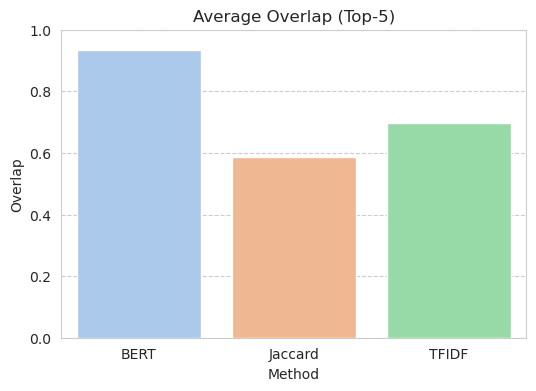

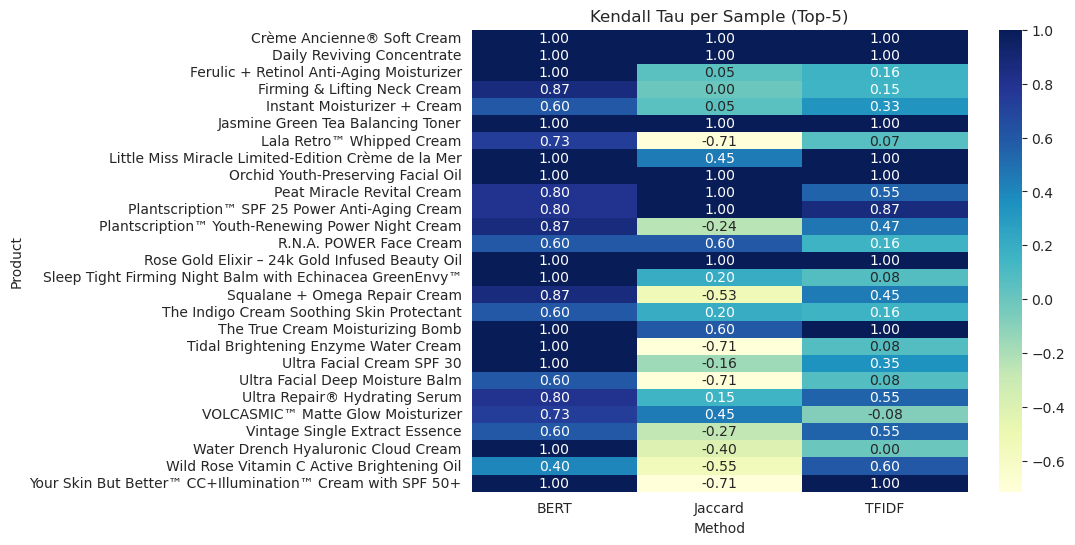

In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.stats import kendalltau
from math import log2
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import jaccard_score
from sklearn.metrics.pairwise import cosine_similarity
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

def jaccard_recommend(df, target_name, top_n):
    df_sub = df[df['Label']=='Moisturizer'].copy().set_index('Name')
    ing_list = df_sub['Ingredients'].apply(lambda x: [i.strip() for i in x.split(',') if i.strip()])
    mlb = MultiLabelBinarizer()
    mat = mlb.fit_transform(ing_list)
    bin_df = pd.DataFrame(mat, index=ing_list.index, columns=mlb.classes_)
    target_vec = bin_df.loc[target_name].values
    sims = bin_df.apply(lambda row: jaccard_score(target_vec, row.values), axis=1)
    sims = sims.drop(index=target_name, errors='ignore')
    return sims.nlargest(top_n).index.tolist()

from sklearn.feature_extraction.text import TfidfVectorizer

def tfidf_recommend(df, target_name, top_n):
    df_sub = df[df['Label']=='Moisturizer'].copy()
    names = df_sub['Name'].tolist()
    texts = df_sub['Ingredients'].astype(str).tolist()
    vect = TfidfVectorizer(token_pattern=r"(?u)\b\w+\b", lowercase=True)
    tfidf_mat = vect.fit_transform(texts)
    idx = names.index(target_name)
    sims = cosine_similarity(tfidf_mat, tfidf_mat[idx]).flatten()
    sims_series = pd.Series(sims, index=names).drop(index=target_name, errors='ignore')
    return sims_series.nlargest(top_n).index.tolist()

def remove_noncore(ingredient_str, non_core_set):
    ing_list = [ing.strip() for ing in ingredient_str.split(',') if ing.strip()]
    core_list = [ing for ing in ing_list if ing.lower() not in non_core_set]
    return ", ".join(core_list) if core_list else ", ".join(ing_list)

def test_recommendation_robustness(df_new, top_n=10, non_core_set=None,
                                   show_example=True, plot=True, random_state=42):
    df_moist = df_new[df_new['Label']=='Moisturizer'].reset_index(drop=True)
    train_df, test_df = train_test_split(df_moist, test_size=0.1, random_state=random_state)
    if non_core_set is None:
        all_ing = []
        for txt in train_df['Ingredients']:
            all_ing.extend([ing.strip().lower() for ing in txt.split(',') if ing.strip()])
        non_core_set = set(pd.Series(all_ing).value_counts().head(10).index.tolist())
    
    metrics = []
    example_done = False
    for _, row in tqdm(test_df.iterrows(), total=len(test_df), desc="Robustness Eval"):
        name = row['Name']
        orig_txt = row['Ingredients']
        clean_txt = remove_noncore(orig_txt, non_core_set)
        if show_example and not example_done:
            #print("  origin:", orig_txt)
            #print("  after clean:", clean_txt)
            example_done = True
        cand_orig = pd.concat([train_df, row.to_frame().T], ignore_index=True)
        cand_clean = pd.concat([train_df, row.to_frame().T.assign(Ingredients=clean_txt)], ignore_index=True)
        orig_j = jaccard_recommend(cand_orig, name, top_n)
        clean_j = jaccard_recommend(cand_clean, name, top_n)
        orig_t = tfidf_recommend(cand_orig, name, top_n)
        clean_t = tfidf_recommend(cand_clean, name, top_n)
        orig_b = list(BERT_Similarity_final(name, cand_orig, top_n=top_n)['Name'])
        clean_b = list(BERT_Similarity_final(name, cand_clean, top_n=top_n)['Name'])
        for method, L1, L2 in [
            ('TFIDF', orig_j, clean_j),
            ('BERT',  orig_t, clean_t),
            ('Jaccard',  orig_b, clean_b)
        ]:
            # Overlap
            overlap = len(set(L1)&set(L2))/top_n
            # Rank Displacement
            common = [i for i in L1 if i in L2]
            disp = np.mean([abs(L1.index(i)-L2.index(i)) for i in common]) if common else top_n
            # Kendall's tau
            union = list(dict.fromkeys(L1+L2))
            r1 = [L1.index(x)+1 if x in L1 else top_n+1 for x in union]
            r2 = [L2.index(x)+1 if x in L2 else top_n+1 for x in union]
            tau, _ = kendalltau(r1, r2)
            # NDCG
            DCG = sum((1 if item in L1 else 0)/log2(idx+2) for idx, item in enumerate(L2))
            IDCG = sum(1/log2(i+2) for i in range(top_n))
            ndcg = DCG/IDCG
            
            metrics.append({
                'Method': method,
                'Product': name,
                'Overlap': overlap,
                'RankDisp': disp,
                'KendallTau': tau,
                'NDCG': ndcg
            })
    
    metrics_df = pd.DataFrame(metrics)
    summary = metrics_df.groupby('Method').mean()[['Overlap','RankDisp','KendallTau','NDCG']]
    display(summary)
    if plot:
        plt.figure(figsize=(6,4))
        sns.barplot(data=summary.reset_index(), x='Method', y='Overlap')
        plt.ylim(0,1); plt.title(f'Average Overlap (Top-{top_n})'); plt.show()
        tau_mat = metrics_df.pivot(index='Product', columns='Method', values='KendallTau')
        plt.figure(figsize=(8,6))
        sns.heatmap(tau_mat, cmap='YlGnBu', annot=True, fmt=".2f")
        plt.title(f'Kendall Tau per Sample (Top-{top_n})'); plt.show()
    
    return metrics_df, summary

metrics_df, summary = test_recommendation_robustness(df_new, top_n=5, show_example=True, plot=True)
